In [38]:
import numpy as np
import pandas as pd
import os
import importlib

In [39]:
import ipynb.fs.full.plotGraph as plotGraph
import ipynb.fs.full.wspMultithreshold as wspMultithreshold
import ipynb.fs.full.dicomHandler as dicomHandler
import ipynb.fs.full.npyHandler as npyHandler

import ipynb.fs.full.wspTsallisEvaluation as wspTsallisEvaluation
import ipynb.fs.full.wspShannonEvaluation as wspShannonEvaluation

importlib.reload(plotGraph)
importlib.reload(wspMultithreshold)
importlib.reload(dicomHandler)
importlib.reload(wspTsallisEvaluation)

<module 'ipynb.fs.full.wspTsallisEvaluation' (/media/webis/Data Both/OneDrive - FEI/Projetos/GitHub/image-segmentation/wspTsallisEvaluation.ipynb)>

### Automatic q Calculation

$$S_{MAX} = \frac{1}{q-1} [1 - n(p^q(x))]$$

In [40]:
q_value = np.linspace(0.01, 1.99, num=199)
#q_value = np.linspace(0.001, 1.999, num=1999)
#q_value = np.linspace(0.0001, 1.9999, num=19999)

In [41]:
q_value[q_value == 1.00] = 1.0000000000001

In [42]:
folder_dir = "Dataset/original"

In [43]:
def get_lb_ub():
    min_pixel_value = float('inf')
    max_pixel_value = float('-inf')

    for filename in os.listdir(folder_dir):
        image_path = os.path.join(folder_dir, filename)
        image = np.load(image_path)
        min_pixel_value = min(min_pixel_value, np.min(image))
        max_pixel_value = max(max_pixel_value, np.max(image))

    return min_pixel_value, max_pixel_value

lb, ub = get_lb_ub()

In [44]:
folder_dir = "Dataset/original"
folder_gt_dir = "Dataset/segmented"

dicom_img = folder_dir + '/CASE_20_1.npy'

In [45]:
lb, ub

(-2000, 4219)

In [46]:
pixel_array = npyHandler.read_npy_image(dicom_img)

#import cv2
#image = cv2.imread("ct.png")
#pixel_array = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#lb,ub = pixel_array.min(), pixel_array.max()

#import matplotlib.image
#matplotlib.image.imsave('ct.png', pixel_array, cmap='gray')

hist, bin_edges, _, _ = wspMultithreshold.wspGrayHistogram(pixel_array)

In [47]:
bin_edges

array([-2000., -1999., -1998., ...,  3299.,  3300.,  3301.])

In [48]:
# N = the  amount  of  elements  of  the X
N = ub - lb + 1

p_x = 1/N

print(N, p_x)

6220 0.0001607717041800643


In [49]:
Sq_Smax_value = []

for q in q_value:
    Sq = wspTsallisEvaluation.TsallisEntropy(hist, q, 0, N)
    
    Smax = 1/(q-1) * (1-(N*((p_x)**q)))
    
    Sq_Smax = Sq / Smax
    Sq_Smax_value.append(Sq_Smax)

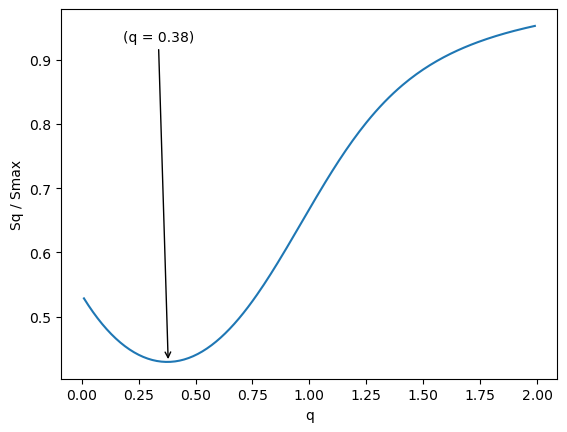

In [50]:
import matplotlib.pyplot as plt

# Example arrays
x = q_value
y = Sq_Smax_value

#lowest_index = np.argmin(y)

sorted_indices = np.argsort(y)
second_lowest_index = sorted_indices[0]

# Plotting the line graph
plt.plot(x, y)

#plt.scatter(x[lowest_index], y[lowest_index], color='red', label='Lowest Point')
annotation_text = f'(q = {x[second_lowest_index]})'
plt.annotate(annotation_text, xy=(x[second_lowest_index], y[second_lowest_index]), xytext=(x[second_lowest_index]-0.2, y[second_lowest_index]+0.5), arrowprops=dict(arrowstyle='->'))

# Adding labels and title
plt.xlabel('q')
plt.ylabel('Sq / Smax')

# Display the plot
plt.savefig("Automatic q value.jpg", bbox_inches='tight')
plt.show()


In [51]:
best_q_values = []

lb, ub = get_lb_ub()

N = ub - lb + 1

p_x = 1/N

In [52]:
for file in os.listdir(folder_dir):
    dicom_img = folder_dir + '/' + file
    pixel_array = npyHandler.read_npy_image(dicom_img)

    hist, bin_edges, _, _ = wspMultithreshold.wspGrayHistogram(pixel_array)

    Sq_Smax_value = []

    for q in q_value:
        Sq = wspTsallisEvaluation.TsallisEntropy(hist, q, 0, len(hist)+1)
        
        Smax = 1/(q-1) * (1-(N*((p_x)**q)))

        Sq_Smax = Sq / Smax
        Sq_Smax_value.append(Sq_Smax)

    sorted_indices = np.argsort(Sq_Smax_value)
    second_lowest_index = sorted_indices[0]

    best_q_values.append(q_value[second_lowest_index])


In [53]:
data = {'q': best_q_values}

In [54]:
np.mean(best_q_values), np.std(best_q_values)

(0.29874074074074075, 0.08628917471806866)

In [55]:
np.min(best_q_values), np.max(best_q_values)

(0.13, 0.42000000000000004)

In [56]:
df = pd.DataFrame(data)

min_counts = df['q'].value_counts().reset_index()
min_counts.columns = ['q', 'Count']

min_counts['%'] = round((min_counts['Count']/270)*100,2)

display(min_counts)

,q,Count,%
0,0.39,33,12.22
1,0.37,26,9.63
2,0.38,24,8.89
3,0.28,17,6.30
4,0.21,15,5.56
5,0.27,14,5.19
6,0.41,13,4.81
7,0.19,13,4.81
8,0.24,11,4.07
9,0.22,11,4.07


In [80]:
df = min_counts.sort_values('q')
df['q'] = df['q'].round(2)

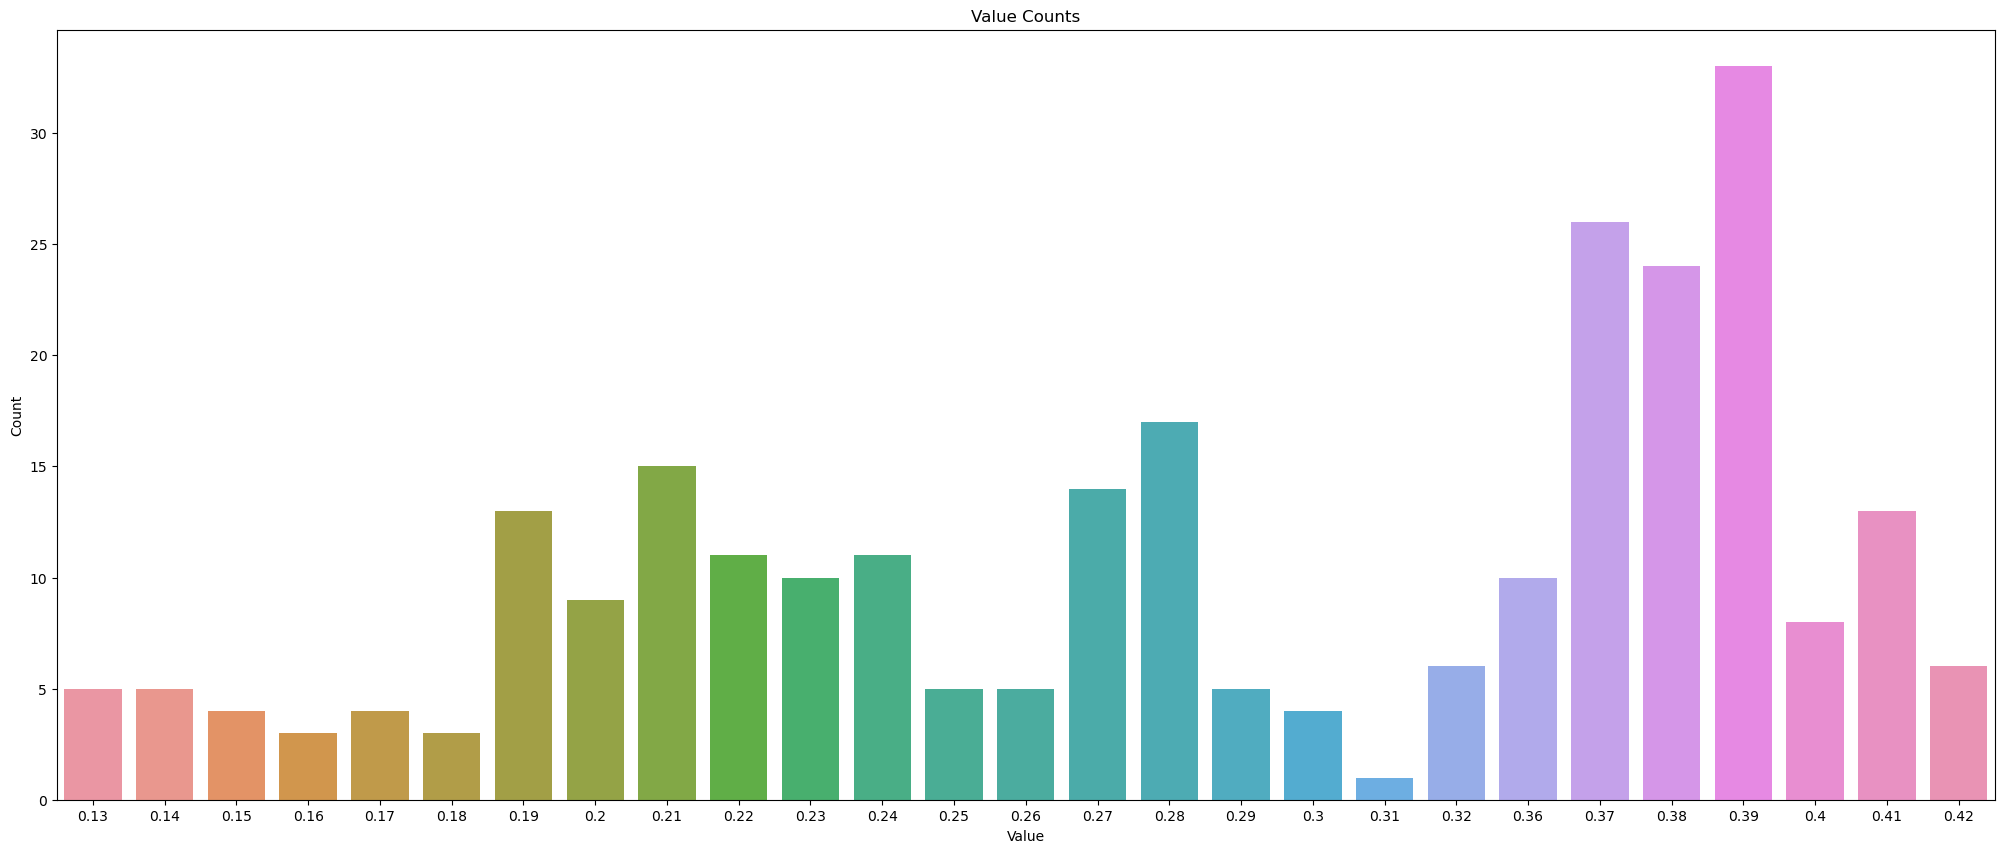

In [81]:
import seaborn as sns

plt.figure(figsize=(25, 10))
sns.barplot(x='q', y='Count', data=df)
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Value Counts')
plt.show()